In [36]:
%matplotlib inline
import os
from io import BytesIO
import time
import requests
import base64
from pathlib import Path
from PIL import Image

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import load_model,Model
import matplotlib.pyplot as plt
import matplotlib

# matplotlib.rcParams['figure.figsize'] = (12,12)
# matplotlib.rcParams['axes.grid'] = False

from utils.utils import *
from utils.model import LossModel, StyleTransferModel
from utils.loss import *
from utils.constants import *
from utils.loader import TensorflowDatasetLoader

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  0


In [30]:
# Pretrained VGG19 model to calculate perceptual loss 
vgg=vgg19.VGG19(weights='imagenet',include_top=False)
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [31]:
# Define content and style layers from pretrained model's layers
content_layers=['block4_conv2']
style_layers=['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

content_layers_weights=[1]
style_layers_weights=[1]*5

In [32]:
# Loss model to calculate perceptual loss = style loss + content loss
loss_model=LossModel(vgg,content_layers,style_layers)

In [34]:
# Define input shape and batch size
input_shape=(image_size,image_size,num_channels)

# Create instance of style model
style_model = StyleTransferModel()
style_model.print_shape(tf.zeros(shape=(1,*input_shape)))

# Initialize optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

(1, 256, 256, 3)
(1, 256, 256, 32)
(1, 128, 128, 64)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 128, 128, 64)
(1, 256, 256, 32)
(1, 256, 256, 3)


In [35]:
# Training step

def train_step(dataset, style_activations, steps_per_epoch, style_model, loss_model, optimizer, checkpoint_path="./", content_weight=1e4, style_weight=1e-2, total_variation_weight=0.004, content_layers_weights=[1], style_layers_weights=[1]*5):
    batch_losses = []   # Batch losses after regularization
    perceptual_losses = []
    content_losses = []
    style_loss = []
    
    steps = 1
    save_path=os.path.join(checkpoint_path,f"model_checkpoint.ckpt")
    print("Model Checkpoint Path: ", save_path)

    for i, input_image_batch in enumerate(dataset):
        if steps >= steps_per_epoch + 1:
            break
        with tf.GradientTape() as tape:
            outputs=style_model(input_image_batch)
            outputs=tf.clip_by_value(outputs, 0, 255)
            pred_activations=loss_model.get_activations(outputs/255.0)
            content_activations=loss_model.get_activations(input_image_batch)["content"] 
            # Perceptual loss
            per_loss, content_loss, style_loss = perceptual_loss(pred_activations,content_activations,style_activations,content_weight,
                                      style_weight,content_layers_weights,style_layers_weights)
            curr_loss = per_loss + total_variation_weight * tf.image.total_variation(outputs)
        
        batch_losses.append(curr_loss) # After regularization
        perceptual_losses.append(per_loss)
        content_losses.append(content_loss)
        style_losses.append(style_loss)

        grad = tape.gradient(curr_loss,style_model.trainable_variables)
        optimizer.apply_gradients(zip(grad,style_model.trainable_variables))

        if steps % 100 == 0:
            print("checkpoint saved ", end = " ")
            style_model.save_weights(save_path)

            bl = tf.reduce_mean(batch_losses).numpy()
            pl = tf.reduce_mean(perceptual_losses).numpy()
            cl = tf.reduce_mean(content_losses).numpy()
            sl = tf.reduce_mean(style_losses).numpy()

            print(f"Loss: {bl}") 
            print(f"Perceptual Loss: {pl}")
            print(f"Content Loss: {cl}")
            print(f"Style Loss: {sl}")

            f.write(f'Step [{steps}]\t Batch loss: [{bl:.4f}]\t Perceptual: [{pl:.4f}]\t Content: [{cl:.4f}]\t Style: [{sl:.4f}]\n')
            f.flush()

        steps+=1

    return tf.reduce_mean(batch_losses), tf.reduce_mean(perceptual_losses), tf.reduce_mean(content_losses), tf.reduce_mean(style_losses)

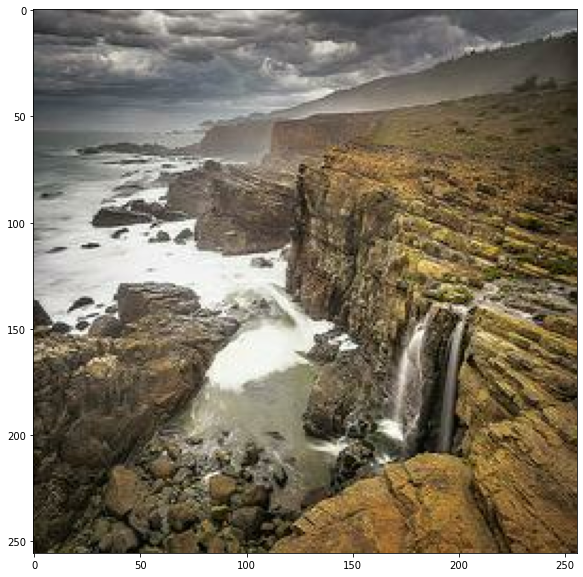

In [18]:
# Load dataset
input_path = "../../data/photo"
style_path = "../../data/monet/monet_"

# Photograph dataset
loader = TensorflowDatasetLoader(input_path, batch_size=batch_size)
loader.dataset.element_spec
plot_images_grid(next(iter(loader.dataset.take(1))),num_rows=4)

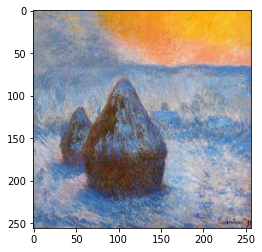

In [19]:
# Set up style image dataset for training
style_image_path = os.path.join(style_path,"3417ace946.jpg")
style_image = load_image(style_image_path,dim=(input_shape[0],input_shape[1]),resize=True)
style_image = style_image/255.0

# Show image
show_image(style_image)

style_image = style_image.astype(np.float32)
style_image_batch = np.repeat([style_image],batch_size,axis=0)
style_activations = loss_model.get_activations(style_image_batch)["style"]

In [20]:
# Training style model 
# epochs = 10
epochs = 1
content_weight = 2*1e1
style_weight = 1e2
total_variation_weight = 0.004

num_images = len(loader)
steps_per_epochs = num_images//batch_size
print(steps_per_epochs)

7038


In [21]:
model_save_path = "model_checkpoint"
os.makedirs(model_save_path,exist_ok=True)

In [22]:
# Enable mix precision and jit for training optimization
try:
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.keras.mixed_precision.experimental.set_policy(policy) 
except:
    pass

try:
    tf.config.optimizer.set_jit(True)
except:
    pass

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [37]:
# Load previous saved checkpoints if exists
if os.path.isfile(os.path.join(model_save_path,"model_checkpoint.ckpt.index")):
    style_model.load_weights(os.path.join(model_save_path,"model_checkpoint.ckpt"))
    print("resuming training ...")
else:
    print("training scratch ...")

resuming training ...


In [38]:
# Train + write losses to log file
f = open("./losses.txt", "a")
f.write("Losses log for VGG19\n")

# Epoch losses
epoch_losses = []
perceptual_losses = []
content_losses = []
style_losses = []

for epoch in range(1,epochs+1):
    print(f"epoch: {epoch}")
    batch_loss, per_loss, content_loss, style_loss = train_step(loader.dataset,
                                                                        style_activations,
                                                                        steps_per_epochs,
                                                                        style_model,
                                                                        loss_model,optimizer,
                                                                        model_save_path,
                                                                        content_weight,
                                                                        style_weight,
                                                                        total_variation_weight,
                                                                        content_layers_weights,
                                                                        style_layers_weights)
    style_model.save_weights(os.path.join(model_save_path,"model_checkpoint.ckpt"))
    print("Model Checkpointed at: ",os.path.join(model_save_path,"model_checkpoint.ckpt"))
    
    epoch_losses.append(batch_loss)
    perceptual_losses.append(per_loss)
    content_losses.append(content_loss)
    style_losses.append(style_loss)

    # Print and write losses to file
    bl = tf.reduce_mean(epoch_losses).numpy()
    pl = tf.reduce_mean(perceptual_losses).numpy()
    cl = tf.reduce_mean(content_losses).numpy()
    sl = tf.reduce_mean(style_losses).numpy()

    f_string = f'EPOCH [{epoch}/{epochs+1}]\t Batch loss: {bl:.4f}\t Perceptual: {pl:.4f}\t Content: {cl:.4f}\t Style: {sl:.4f}\n\n'
    print(f_string)
    f.write(f_string)
    f.flush()

f.close()

epoch: 1
Model Checkpoint Path:  model_checkpoint/model_checkpoint.ckpt


KeyboardInterrupt: 

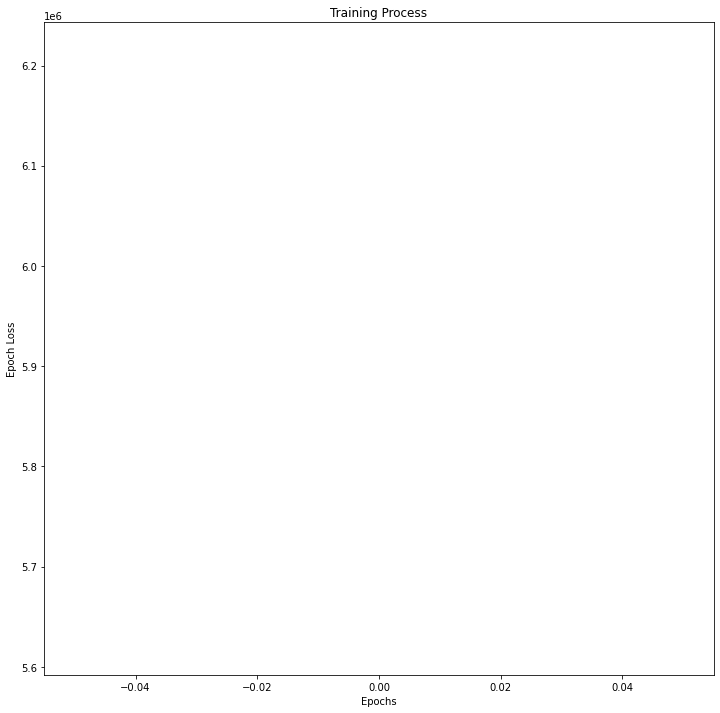

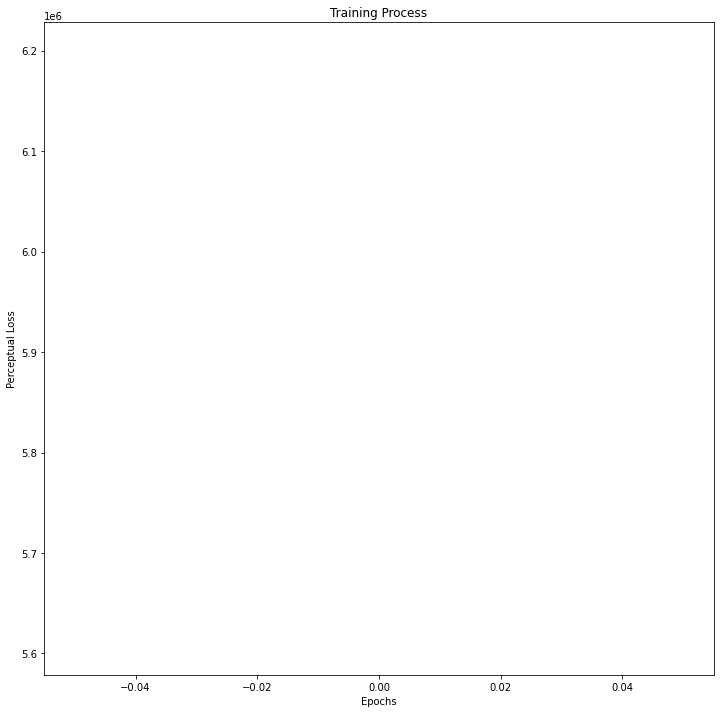

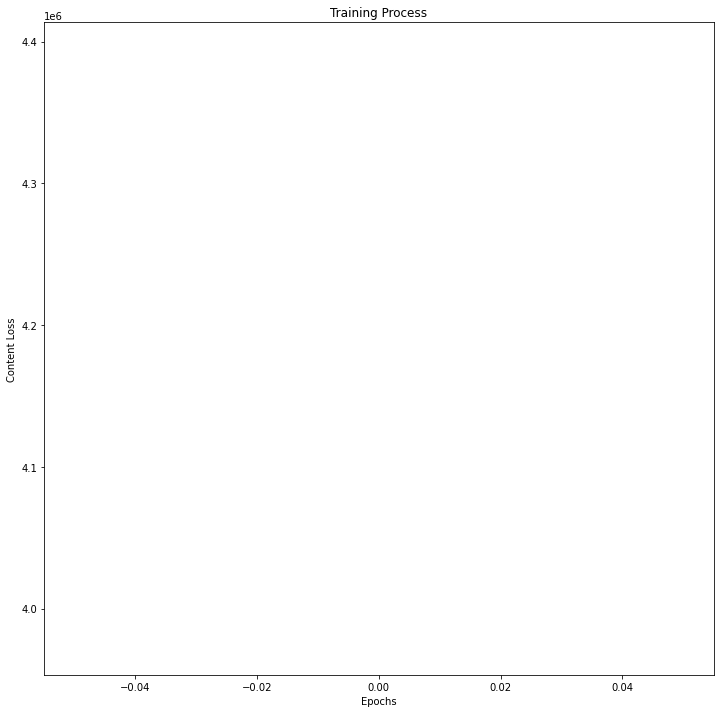

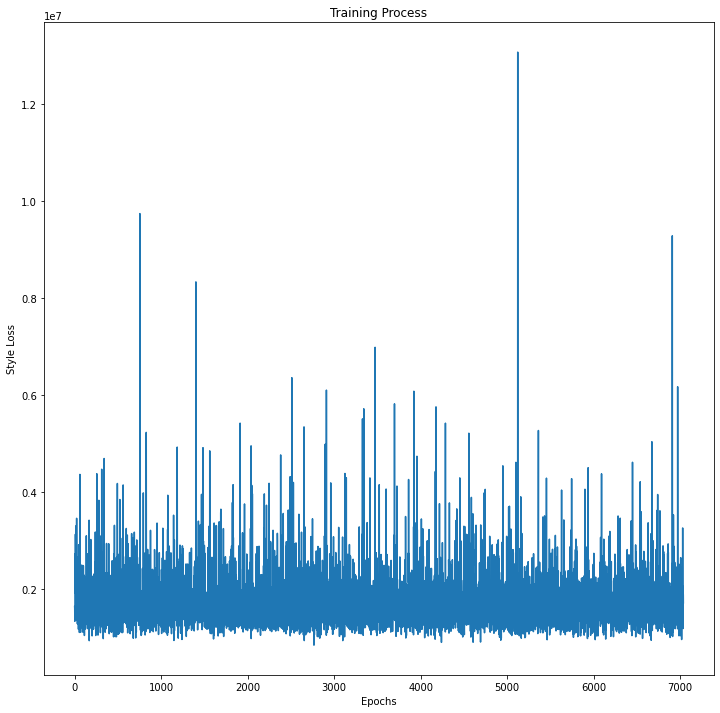

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

In [27]:
# Plot losses-----------------------------
plt.figure()
plt.plot(epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Epoch Loss")
plt.title("Training Process")
plt.show()

plt.figure()
plt.plot(perceptual_losses)
plt.xlabel("Epochs")
plt.ylabel("Perceptual Loss")
plt.title("Training Process")
plt.show()

plt.figure()
plt.plot(content_losses)
plt.xlabel("Epochs")
plt.ylabel("Content Loss")
plt.title("Training Process")
plt.show()

plt.figure()
plt.plot(style_losses)
plt.xlabel("Epochs")
plt.ylabel("Style Loss")
plt.title("Training Process")
plt.show()
plt.figure()

In [22]:
# Generate artworks
styled_images = []

for images in loader.dataset.take(1):
    images = images * 255.0
    generated_images = style_model(images)
    generated_images = np.clip(generated_images,0,255)
    generated_images = generated_images.astype(np.uint8)
    for image in generated_images:
        styled_images.append(image)

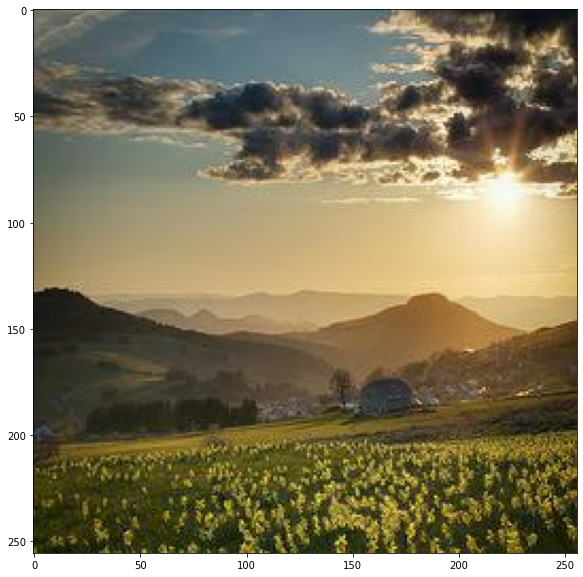

In [23]:
# Plot original photographs
plot_images_grid(next(iter(loader.dataset.take(1))),num_rows = 4)

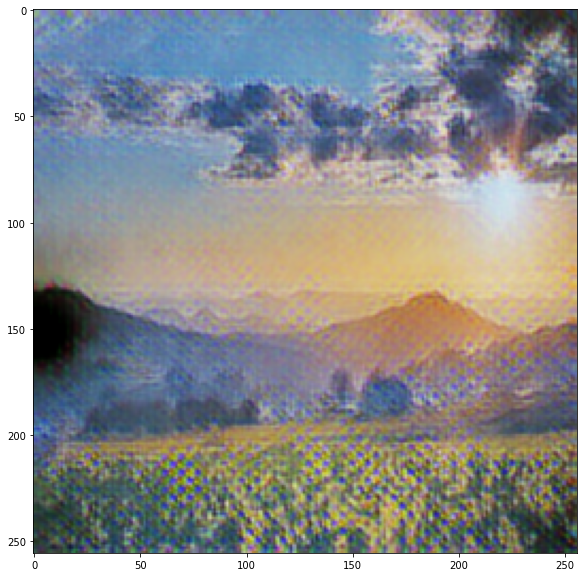

In [24]:
# Plot styled images
plot_images_grid(styled_images,num_rows = 4)

In [25]:
# Save results
# TODO: Make file name the same as original photograph for easier comparison 
os.makedirs('./results',exist_ok=True)

i = 1
for images in loader.dataset.take(500):
    images = images * 255.0
    generated_images = style_model(images)
    generated_images = np.clip(generated_images,0,255)
    generated_images = generated_images.astype(np.uint8)
    for image in generated_images:
        img = Image.fromarray(image)
        img.save(os.path.join('./results',f'{i}.jpg'))
        i = i + 1
